## 6.2 计算性能
本小节我们主要介绍与深度学习计算相关的**硬件与编译基础知识**，详细内容可见[d2l课程官网](https://zh.d2l.ai/chapter_computational-performance/hybridize.html), 若想学习机器学习编译(Machine Learning Compilation)相关知识，可以观看陈天奇的这门[课程](https://mlc.ai/summer22-zh/schedule), 和我本人对这门课程做的[简单笔记](https://github.com/Gary-code/MLC-Notes)

### 6.2.1 深度学习硬件: CPU 和 GPU

#### 6.2.1.1 CPU
下图为一张`i7 - 6700K`的结构图:
![](https://raw.githubusercontent.com/Gary-code/Machine-Learning-Park/files/blogImgs/20211123201018.png)

为此我们通常会思考如何提升**CPU利用率**?
我们结合计算机组成原理中学到的知识来进行回答：
![](https://raw.githubusercontent.com/Gary-code/Machine-Learning-Park/files/blogImgs/20211123201054.png)

答案就是利用CPU的**多核**, 下面进行一个简单样例的分析:
![](https://raw.githubusercontent.com/Gary-code/Machine-Learning-Park/files/blogImgs/20211124195623.png)
![](https://raw.githubusercontent.com/Gary-code/Machine-Learning-Park/files/blogImgs/20211124200011.png)

#### 6.2.1.2 GPU
下图是一张英伟达`Titan X`的示意图：
![](https://raw.githubusercontent.com/Gary-code/Machine-Learning-Park/files/blogImgs/20211124200131.png)

对比CPU：
* 多核和内存带宽高
* 但牺牲的就是内存不能做太大（太贵了）

![](https://raw.githubusercontent.com/Gary-code/Machine-Learning-Park/files/blogImgs/20211124201333.png)
![](https://raw.githubusercontent.com/Gary-code/Machine-Learning-Park/files/blogImgs/20211124201547.png)

需要注意的是, 由于带宽限制和同步的开销，**不要在CPU和GPU之间来回跳转**。

### 6.2.1.3 其他计算处理器
* 高通845平台

![](https://raw.githubusercontent.com/Gary-code/Machine-Learning-Park/files/blogImgs/20211124201645.png)

* DSP：数字信号处理
![](https://i.loli.net/2021/11/24/y1HcrflCM87PTua.png)

* 可编程阵列（FPGA）
![](https://i.loli.net/2021/11/24/FUCpV7diZGgnP89.png)

* AI ASIC
![](https://i.loli.net/2021/11/24/a6O8XEHZoYf1AN7.png)

### 6.2.2 单机多卡并行

* 小批量可以切割到不同GPU当中去并行加速
* 常用切分方案
  * 数据并行（主要的）
  * 模型并行
  * 通道并行

**数据并行**
* 将小批量分成n块，每个GPU拿到完整参数计算一块数据的梯度
* 通常性能更好

  ![](https://i.loli.net/2021/11/27/BaFmJitxjCzZP1q.png)

> 对数据来说并行

1. 读一个数据块
2. 拿回参数
3. 计算梯度
4. 发出梯度
5. 更新梯度

**模型并行**:
* 将模型分成n块，每个GPU拿到一块模型计算它的前向和方向结果
* 通常用于模型大到单GPU放不下


**总结**：
* 当一个模型可以在单卡计算时候，通常使用数据并行到多卡
* 模型并行主要用在超大型的模型上

### 6.2.3 分布式计算

#### 6.2.3.1 基础概念
**基本上等于单机多卡**

![](https://i.loli.net/2021/12/01/Kl9QiNgjdGM3wbz.png)

GPU机器架构

![](https://i.loli.net/2021/12/01/qVcm9RsSzb2Hh8T.png)



**计算一个小批量**

![](https://i.loli.net/2021/12/01/8nA9hwHeW6kotql.png)



同步SGD

* 这里每个worker都是同步计算一个批量 , 称为同步SGD
* 假设有n个GPU，每个GPU每次处理b个样本，那么同步SGD等价于在单GPU运行批量大小为nb的SGD
* **在理想情况下**，n个GPU可以得到相对个单GPU的n倍加速.

性能

* $t_1$=在单GPU上计算b个样本梯度时间
* 假设有m个参数，1个worker每次发送和接收m个参数、梯度
  * $t_2$=发送和接收所用时间
* 每个批量的计算时间为$max(t_1, t_2)$
  * 选取足够大的b使得$t_1>t_2$
  * **增加b或n**导致更大的批量大小，导致需要更多计算来得到给定的模型精度(**收敛变慢**)

![](https://i.loli.net/2021/12/01/HEpyleNJmkdcLsz.png)

#### 6.2.3.2 代码实践

* **使用一个大数据集**
* 需要好的GPU-GPU和机器机器**带宽**
* **高效的数据读取和预处理**
* 模型需要有好的计算(FLOP)通讯(model size)比
  * `Inception`> `ResNet` > `AlexNet`
* 使用足够大的批量大小来得到好的系统性能，
* 使用**高效的优化算法对对应大批量大小**

下面我们通过代码来实践一下多GPU计算(**由于本机无Nvidia的GPU，因此部分代码并未成功执行**)：

* 从零开始实现

In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [7]:
# 初始化模型参数
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]

# 定义模型
def lenet(X, params):
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat

# 交叉熵损失函数
loss = nn.CrossEntropyLoss(reduction='none')


In [4]:
# 数据同步
def get_params(params, device):
    # 参数放到GPU上
    new_params = [p.clone().to(device) for p in params]
    for p in new_params:
        p.requires_grad_()
    return new_params

In [8]:
new_params = get_params(params, d2l.try_gpu(0))
print('b1 weight:', new_params[1])
print('b1 grad:', new_params[1].grad)

b1 weight: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True)
b1 grad: None


In [9]:
# 将所有向量相加，并将结果广播给所有GPU
def allreduce(data):
    for i in range(1, len(data)):  # 先全部放到data[0]中，第0个GPU
        data[0][:] += data[i].to(data[0].device)
    for i in range(1, len(data)):
        data[i] = data[0].to(data[i].device)

In [10]:
data = [torch.ones((1, 2), device=d2l.try_gpu(i)) * (i + 1) for i in range(2)]
print('before allreduce:\n', data[0], '\n', data[1])
allreduce(data)
print('after allreduce:\n', data[0], '\n', data[1])

before allreduce:
 tensor([[1., 1.]]) 
 tensor([[2., 2.]])
after allreduce:
 tensor([[3., 3.]]) 
 tensor([[3., 3.]])


In [11]:
data = torch.arange(20).reshape(4, 5)
devices = [torch.device('cuda:0'), torch.device('cuda:1')]
split = nn.parallel.scatter(data, devices)  # 均匀切入对应GPU中
print('input :', data)
print('load into', devices)
print('output:', split)

AttributeError: module 'torch._C' has no attribute '_scatter'

In [12]:
def split_batch(X, y, devices):
    """将`X`和`y`拆分到多个设备上"""
    assert X.shape[0] == y.shape[0]
    return (nn.parallel.scatter(X, devices),
            nn.parallel.scatter(y, devices))

In [13]:
# 训练
def train_batch(X, y, device_params, devices, lr):
    X_shards, y_shards = split_batch(X, y, devices)
    # 在每个GPU上分别计算损失
    ls = [loss(lenet(X_shard, device_W), y_shard).sum()
          for X_shard, y_shard, device_W in zip(
            X_shards, y_shards, device_params)]
    for l in ls:  # 反向传播在每个GPU上分别执行
        l.backward()
    # 将每个GPU的所有梯度相加，并将其广播到所有GPU
    with torch.no_grad():
        for i in range(len(device_params[0])):
            allreduce([device_params[c][i].grad
                       for c in range(len(devices))])
    # 在每个GPU上分别更新模型参数
    for param in device_params:
        d2l.sgd(param, lr, X.shape[0]) # 在这里，我们使用全尺寸的小批量

ValueError: Expected a non cpu device, but got: cpu

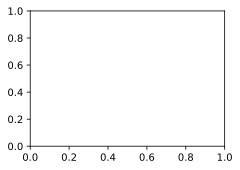

In [15]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    # 将模型参数复制到`num_gpus`个GPU
    device_params = [get_params(params, d) for d in devices]
    num_epochs = 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            # 为单个小批量执行多GPU训练
            train_batch(X, y, device_params, devices, lr)
            torch.cuda.synchronize()  # 同步，用于算时间
        timer.stop()
        # 在GPU 0上评估模型
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(
            lambda x: lenet(x, device_params[0]), test_iter, devices[0]),))
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch '
          f'on {str(devices)}')

In [ ]:
train(num_gpus=2, batch_size=256, lr=0.2)

* 简洁实现

`ResNet18`

In [17]:
#@save
def resnet18(num_classes, in_channels=1):
    """稍加修改的 ResNet-18 模型。"""
    def resnet_block(in_channels, out_channels, num_residuals,
                     first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(d2l.Residual(in_channels, out_channels,
                                        use_1x1conv=True, strides=2))
            else:
                blk.append(d2l.Residual(out_channels, out_channels))
        return nn.Sequential(*blk)

    # 该模型使用了更小的卷积核、步长和填充，而且删除了最大汇聚层。
    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU())
    net.add_module("resnet_block1", resnet_block(64, 64, 2, first_block=True))
    net.add_module("resnet_block2", resnet_block(64, 128, 2))
    net.add_module("resnet_block3", resnet_block(128, 256, 2))
    net.add_module("resnet_block4", resnet_block(256, 512, 2))
    net.add_module("global_avg_pool", nn.AdaptiveAvgPool2d((1,1)))
    net.add_module("fc", nn.Sequential(nn.Flatten(),
                                       nn.Linear(512, num_classes)))
    return net

In [18]:
net = resnet18(10)
# 获取GPU列表
devices = d2l.try_all_gpus()
# 我们将在训练代码实现中初始化网络

In [19]:
def train(net, num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    def init_weights(m):
        if type(m) in [nn.Linear, nn.Conv2d]:
            nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)
    # 在多个 GPU 上设置模型
    net = nn.DataParallel(net, device_ids=devices)  # 切开放到多个GPU中
    trainer = torch.optim.SGD(net.parameters(), lr)
    loss = nn.CrossEntropyLoss()
    timer, num_epochs = d2l.Timer(), 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        net.train()
        timer.start()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(devices[0]), y.to(devices[0])
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        timer.stop()
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(net, test_iter),))
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch '
          f'on {str(devices)}')

In [ ]:
train(net, num_gpus=2, batch_size=256, lr=0.1)

#### 6.2.3.4 总结

* 分布式同步数据并行是多GPU数据并行在多机器上的拓展
* 网络通讯通常是瓶颈
* 需要注意使用**特别大的批量大小时收敛效率**
* 更复杂的分布式有异步、模型并行